# Итоговоый проект по курсу "Библиотеки Python для Data Science" <a class='anchor' id='begin'>

Тема: "Построение модели машинного обучения по предсказанию стоимости недвижимости"<br>
Студент: Николай Пахомов ([kaggle](https://www.kaggle.com/kikoooiemama), [telegram](https://t.me/kikoooiemama))<br>
Преподаватель: Никита Варганов<br>

## Содержание
* [Итоговоый проект по курсу "Библиотеки Python для Data Science"](#begin) 
    * [Задание](#task)
    * [Загрузка библиотек и скриптов](#load_help)
    * [Загрузка данных](#load_data)
    * [1. Анализ данных](#eda)
    * [2. Обработка выбросов и пропусков](#nan)
    * [3. Построение новых признаков](#features)
    * [4. Отбор признаков](#features_selection)
    * [5. Разбиение на train и test](#split)
    * [6. Построение модели](#modeling)
    * [7. Прогнозирование на тестовом датасете](#prediction)

---
## Задание <a class='anchor' id='task'>

_Заданием является предсказание цены на квартиры в датасете test.csv (содержит только признаки), используя тренировачный датасет train.csv (содержит признаки и цены на квартиры)._
    
    
**Материалы к проекту (файлы):** 
* [train.csv](https://www.kaggle.com/c/real-estate-price-prediction-moscow/data?select=train.csv), 
* [test.csv](https://www.kaggle.com/c/real-estate-price-prediction-moscow/data?select=test.csv),
* [sample_submission.csv](https://www.kaggle.com/c/real-estate-price-prediction-moscow/data?select=sample_submission.csv)

**Целевая переменная:**
Price (Цена)

**Основная метрика:**
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

**Вспомогательная метрика:**
MSE - среднеквадратическая ошибка (sklearn.metrics.mean_squared_error)

**Сдача проекта:**
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price). В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

**Сроки сдачи:**
* Рекомендуемый дедлайн: 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту")
* Критический дедлайн: до 2 окт., 20:00 MSK включительно

<u>Если студент не сдаст работу до критического дедлайна, то его работа проверена не будет. Нужно уважать время преподавателя.</u>

**Примечание:**
Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.
    
**Рекомендации для файла с кодом (ipynb):**
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение моделей машинного обучения из библиотеки sklearn.

---
## Загрузка библиотек и скриптов <a class='anchor' id='load_help'>

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """       
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [3]:
def reduce_mem_usage(df):
    """ 
    Выполнение итерации по всем столбцам фрейма данных, чтобы изменить тип данных для уменьшения используемой памяти.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
def type_conversion(df):
    """ 
    Преобразование типов признаков датасета:
        Id, DistrictId - номер квартиры/номер района необходимо убрать из вещественных признаков;
        Rooms, HouseFloor - количество комнат/количество этажей в доме преобразовываем в целочисленный тип данных.
    """
    print(f"'Id' type: {type(train_df['Id'][0])} -> str")
    df['Id'] = df['Id'].astype(str)
    print(f"'DistrictId' type: {type(train_df['DistrictId'][0])} -> str")
    df['DistrictId'] = df['DistrictId'].astype(str)
    print(f"'Rooms' type: {type(train_df['Rooms'][0])} -> str")    
    df['Rooms'] = df['Rooms'].astype('int64')
    print(f"'HouseFloor' type: {type(train_df['HouseFloor'][0])} -> str")  
    df['HouseFloor'] = df['HouseFloor'].astype('int64')
    df = reduce_mem_usage(df)
    return df 

---
## Загрузка данных <a class='anchor' id='load_data'>

### Описание датасета
* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры


### Путь к директориям и файлам

In [5]:
TRAIN_DATASET_PATH = './train.csv' # y_train, y_valid
TEST_DATASET_PATH = './test.csv' # y_test
SUBMIT_DATASET_PATH = './sample_submission.csv'
SUBMIT_FILE_NAME = 'pakhomov_predictions.csv'

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [7]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [8]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [9]:
train_df.shape, test_df.shape

((10000, 20), (5000, 19))

In [10]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [11]:
train_df.shape[1]-1 == test_df.shape[1]

True

### Приведение типов

In [12]:
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [13]:
test_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [14]:
train_df = type_conversion(train_df)
test_df = type_conversion(test_df)

'Id' type: <class 'numpy.int64'> -> str
'DistrictId' type: <class 'numpy.int64'> -> str
'Rooms' type: <class 'numpy.float64'> -> str
'HouseFloor' type: <class 'numpy.float64'> -> str
Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.77 MB
Decreased by 49.7%
'Id' type: <class 'str'> -> str
'DistrictId' type: <class 'str'> -> str
'Rooms' type: <class 'numpy.int8'> -> str
'HouseFloor' type: <class 'numpy.int8'> -> str
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.36 MB
Decreased by 50.3%


In [15]:
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  category
 1   DistrictId     10000 non-null  category
 2   Rooms          10000 non-null  int8    
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  int8    
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [16]:
test_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   category
 1   DistrictId     5000 non-null   category
 2   Rooms          5000 non-null   int8    
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int8    
 7   HouseFloor     5000 non-null   int8    
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

---
## 1. Анализ данных <a class='anchor' id='eda'>

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  category
 1   DistrictId     10000 non-null  category
 2   Rooms          10000 non-null  int8    
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  int8    
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [18]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3,115.027313,NaN,10.0,4,10,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1,39.832523,23.169222,8.0,7,8,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3,78.342216,47.671970,10.0,2,17,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1,40.409908,NaN,1.0,10,22,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2,64.285065,38.562515,9.0,16,16,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750


### Целевая переменная

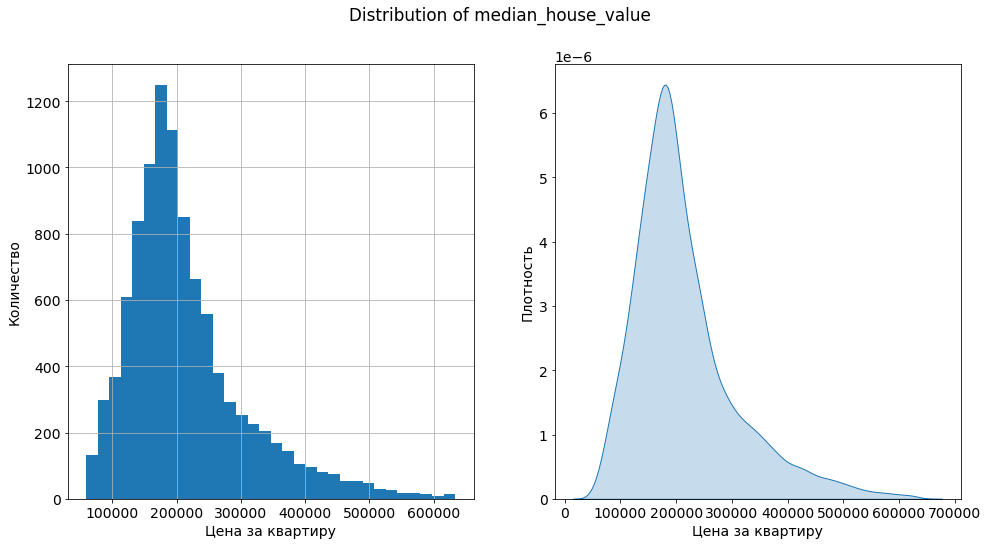

In [19]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist(density=False, bins=32)
plt.ylabel('Количество')
plt.xlabel('Цена за квартиру')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('Цена за квартиру')
plt.ylabel('Плотность')

plt.suptitle('Distribution of median_house_value')
plt.show()

In [20]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]

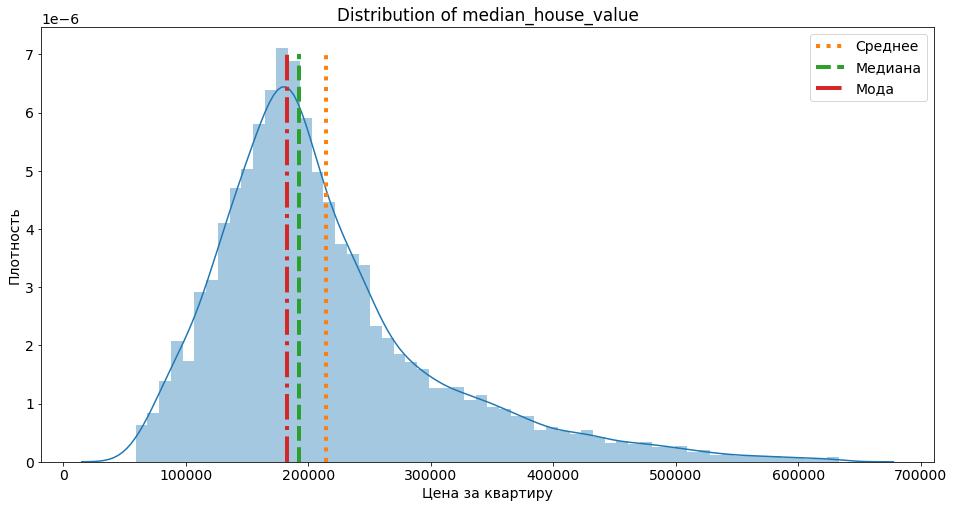

In [21]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=60)

y = np.linspace(0, 0.000007, 10)
plt.plot([target_mean] * 10, y, label='Среднее', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='Медиана', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='Мода', linestyle='-.', linewidth=4)
plt.xlabel('Цена за квартиру')
plt.ylabel('Плотность')

plt.title('Distribution of median_house_value')
plt.legend()
plt.show()

In [22]:
price_mean = train_df['Price'].mean()
price_median = train_df['Price'].median()
price_mode = train_df['Price'].mode()[0]
price_mean, price_median, price_mode

(214138.9375, 192269.65625, 182938.08)

В принципе целевая переменная распределена нормально, никаких выбросов не наблюдается.

### Количественные признаки

In [23]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839512,21.058716,86.241219,28.560839,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


***Rooms***<br>
Среднее значение вроде бы нормальное, минимальное значение вызывает вопросы, поскольку непонятно что означает 0. Это может быть либо ошибка, либо какая-нибудь квартира студия. Максимальное значение вполне может быть реальным, но в нашем случае 75% квартир имеют <= 2 комнат. Поэтому квартиру с 19 комнатами стоит посчитать выбросом.

***Square***<br>
Минимальная площадь похожа на ошибку. Нужно проверить что за квартира с максимальной площадью.

***LifeSquare, KitchenSquare***<br>
Сумма данных площадей не должна привышать суммарную. Мы уже видим что максимальная площадь явно некорректная, так как максимальная общая площадь значительно ниже. С минимальной площадью тоже надо разбираться, могут ли быть квартиры без кухни или без жилой площади непонятно. Также LifeSquare имеет пропуски, только 7887 non-null.

***HouseFloor***<br>
Непонятно почему минимальное значение 0 и стоит ли считать значение 117 этажей за выброс.

Также заметить что пропуски имеет ***Healthcare_1***, только 5202 non-null. Так как мы не знаем что это такое, то данный признак, наверное, можно убрать.

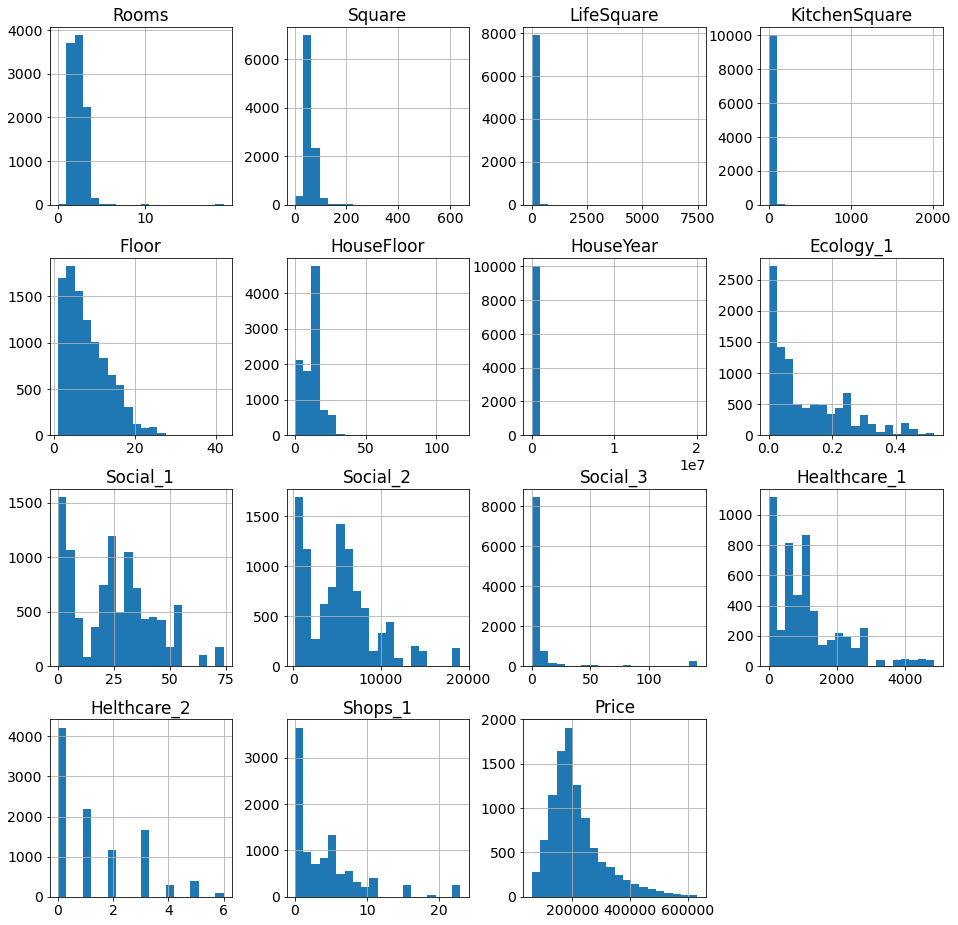

In [24]:
train_df.hist(figsize=(16,16), bins=20, grid=True)
plt.show()

#### Rooms

In [25]:
train_df['Rooms'].value_counts().sort_index()

0        8
1     3705
2     3880
3     2235
4      150
5       18
6        1
10       2
19       1
Name: Rooms, dtype: int64

In [26]:
train_df[train_df['Rooms'] > 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2004,5927,57,10,59.056976,36.223072,10.0,22,22,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.312500
2728,14865,9,10,60.871265,38.420681,10.0,3,2,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.265625
6088,8491,1,19,42.006046,21.779287,7.0,17,17,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.617188
8794,14003,99,6,59.414333,38.702244,6.0,7,9,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.968750


In [27]:
train_df[train_df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2194,3159,88,0,38.697117,19.345131,9.0,9,16,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.109375
3780,7317,27,0,41.790882,NaN,0.0,13,0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976562
5894,770,28,0,49.483501,NaN,0.0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.343750
6401,9443,27,0,87.762619,85.125473,0.0,5,15,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.921875
7644,7917,27,0,212.932358,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.250000
7929,456,6,0,81.491447,NaN,0.0,4,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.796875
9767,12638,27,0,138.427689,136.215500,0.0,4,3,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.750000
9869,3224,27,0,2.377248,0.873147,0.0,1,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.945312


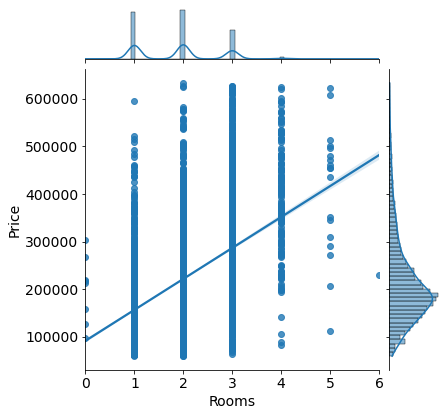

In [28]:
mask = train_df['Rooms'] < 7
grid = sns.jointplot(train_df[mask]['Rooms'], train_df[mask]['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)
plt.show()

Квартир с нулевым количеством комнат очень мало, а также их площадь сильно разнится, возможно это даже не квартиры, а какие то большие офисные помещения. Стоит исключить значения, где количество комнат равно 0, для тренировочной выборки. А для тестовой выборки стоит произвести замену.

Квартиры с количеством комнат > 6 и < 1 считаем выбросом.


<u>Обработка выбросов:</u> Так как выброса немного, то просто установим значение среднего/медианы

<u>Обработка пропусков:</u> Пропусков нет.

#### Square

In [29]:
train_df['Square'].value_counts().sort_index()

1.136859      1
1.988943      1
2.377248      1
2.596351      1
2.954309      1
             ..
212.932358    1
275.645294    1
409.425171    1
604.705994    1
641.065186    1
Name: Square, Length: 9995, dtype: int64

In [30]:
train_df['Square'].sort_values().tail(8)

1606    190.857681
9307    198.930176
1776    200.334534
7644    212.932358
1906    275.645294
7010    409.425171
726     604.705994
9229    641.065186
Name: Square, dtype: float32

In [31]:
train_df[train_df['Square'] > 250]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
726,28,9,2,604.705994,NaN,1.0,17,18,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.250000
1906,5548,86,5,275.645294,233.949310,26.0,12,37,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.875000
7010,2307,102,1,409.425171,410.639740,10.0,4,4,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.429688
9229,11602,30,2,641.065186,638.163208,10.0,20,19,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.687500


In [32]:
train_df[train_df['Square'] < 20].sort_values(by='Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7470,14786,1,1,1.136859,4.525736,1.0,3,1,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.828125
4496,15744,34,1,1.988943,2.642219,1.0,21,4,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.781250
9869,3224,27,0,2.377248,0.873147,0.0,1,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.945312
8572,10202,6,1,2.596351,4.604943,1.0,3,25,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.593750
161,6782,45,1,2.954309,5.257278,1.0,3,1,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.187500
8805,10527,27,1,4.380726,40.805836,1.0,10,17,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.718750
328,4504,27,3,4.390331,5.610772,1.0,8,19,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.062500
4800,7657,38,1,4.502784,4.618547,1.0,28,1,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.500000
5009,11526,27,1,4.633498,1.969969,1.0,18,1,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.265625
9067,13265,1,3,4.823679,79.767967,0.0,6,17,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.687500


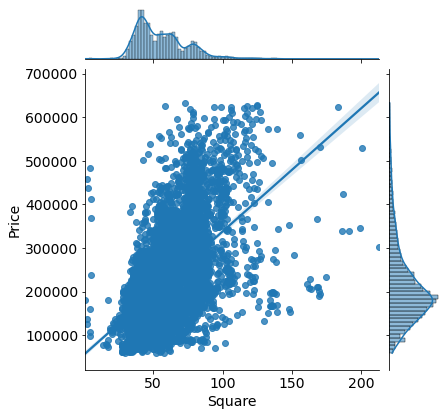

In [33]:
mask = train_df['Square'] < 250
grid = sns.jointplot(train_df[mask]['Square'], train_df[mask]['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)
plt.show()

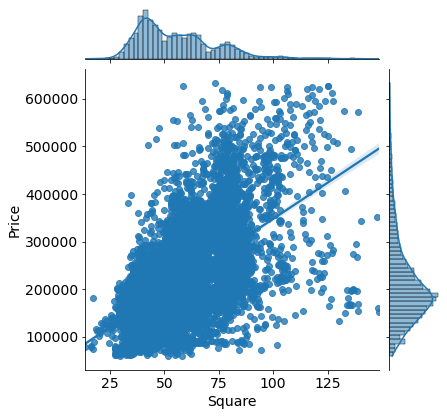

In [34]:
mask = (train_df['Square'] < 150) & (train_df['Square'] > 8)
grid = sns.jointplot(train_df[mask]['Square'], train_df[mask]['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)
plt.show()

Есть аномалии. Есть маленькие значения площади, которые никак не могут подходить под описание квартиры. Также есть квартиры с чересчур большой площадью.

<u>Обработка выбросов:</u> Выбросами считаем квартиры с площадью до 8 и квартиры площадью больше 250. Дропаем все значения, чьи площади больше 250. Для значений меньше 8 проставим случайное значение в интервале [mean - 1.5std; mean + 1.5std], среднее и ско расчитывается согласно количеству комнат в квартире. Площадь квартиры от 8 до 150.

<u>Обработка пропусков:</u> Пропусков нет.

**LifeSqaure**

In [35]:
train_df['Square'].value_counts().sort_index()

1.136859      1
1.988943      1
2.377248      1
2.596351      1
2.954309      1
             ..
212.932358    1
275.645294    1
409.425171    1
604.705994    1
641.065186    1
Name: Square, Length: 9995, dtype: int64

In [36]:
mask = train_df["Square"] < train_df["KitchenSquare"] + train_df["LifeSquare"]
train_df.loc[mask].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,845.000000,313.000000,845.000000,845.000000,845.000000
mean,1.766864,59.145473,68.782043,11.160947,9.797633,14.101775,2000.353846,0.105389,16.360947,3771.007101,8.663905,882.322693,0.871006,3.528994,200907.609375
std,0.824012,32.663059,257.842865,97.293098,6.024869,8.652264,19.752893,0.109640,17.079439,3982.369298,28.699550,721.557373,1.368631,5.267550,99063.882812
min,1.000000,1.136859,1.626502,0.000000,1.000000,0.000000,1918.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59877.593750
25%,1.000000,41.481907,41.675762,1.000000,5.000000,9.000000,1977.000000,0.014073,2.000000,629.000000,0.000000,540.000000,0.000000,0.000000,133166.156250
50%,2.000000,53.258610,53.983730,1.000000,8.000000,17.000000,2015.000000,0.072158,8.000000,1564.000000,1.000000,705.000000,0.000000,1.000000,177948.140625
75%,2.000000,68.767143,68.712204,10.000000,14.000000,17.000000,2017.000000,0.195781,26.000000,6207.000000,4.000000,1046.000000,1.000000,5.000000,237969.140625
max,5.000000,641.065186,7480.592285,2014.000000,28.000000,117.000000,2020.000000,0.486246,74.000000,19083.000000,141.000000,4508.000000,6.000000,23.000000,621002.937500


In [37]:
train_df[train_df['LifeSquare'] > train_df['Square']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
33,847,74,2,73.314972,74.131264,1.0,7,6,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,254005.375000
64,3992,1,3,87.200623,87.730225,0.0,21,22,1977,0.007122,B,B,1,264,0,NaN,0,1,B,300180.375000
77,11771,45,1,38.467278,39.624493,1.0,11,9,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,247440.531250
100,13343,74,2,79.937668,82.931595,1.0,8,21,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,226808.750000
111,13875,20,1,28.438793,32.514023,6.0,6,10,2014,0.019509,B,B,37,7687,11,176.0,5,5,B,199248.109375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3,96.056786,98.152802,1.0,15,1,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.562500
9962,14175,14,1,42.029175,44.682167,10.0,4,4,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,87556.382812
9979,2201,6,1,40.043236,41.984322,1.0,3,17,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,134888.078125
9987,11665,1,2,62.690056,64.602936,10.0,19,22,2018,0.007122,B,B,1,264,0,NaN,0,1,B,203908.187500


In [38]:
train_df[train_df['LifeSquare'] < 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
26,8553,88,3,83.262527,4.769175,1.0,13,1,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,410883.906250
119,5112,6,2,63.591740,0.795539,10.0,17,17,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,174742.000000
161,6782,45,1,2.954309,5.257278,1.0,3,1,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.187500
212,1182,27,1,38.936985,3.064320,0.0,18,19,2017,0.211401,B,B,9,1892,0,NaN,0,1,B,93560.789062
227,3746,62,1,46.722042,1.944446,1.0,11,12,2018,0.072158,B,B,2,629,1,NaN,0,0,A,133721.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9462,10079,59,1,48.232742,3.288779,1.0,15,17,2017,0.019509,B,B,37,7687,11,176.0,5,5,B,207086.640625
9869,3224,27,0,2.377248,0.873147,0.0,1,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.945312
9912,13523,23,1,52.787090,5.600609,1.0,7,1,2015,0.014073,B,B,2,475,0,NaN,0,0,B,104160.492188
9938,2913,34,4,94.888596,2.637095,1.0,4,1,2018,0.069753,B,B,53,13670,4,NaN,1,11,B,346949.500000


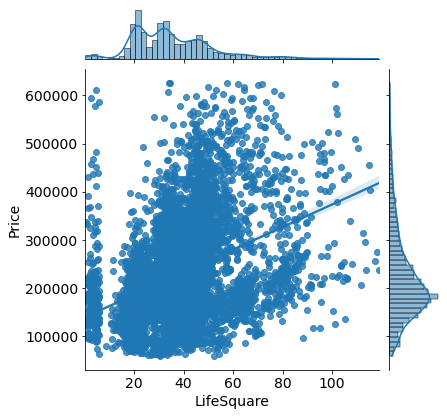

In [39]:
mask = train_df['LifeSquare'] < 120
grid = sns.jointplot(train_df[mask]['LifeSquare'], train_df[mask]['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)
plt.show()

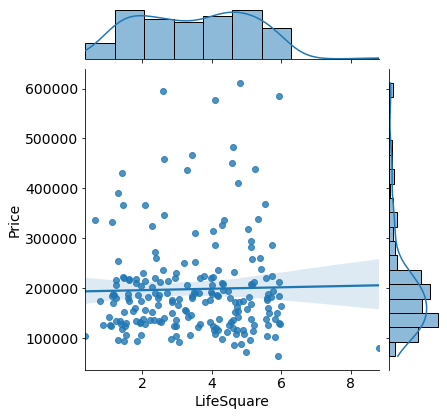

In [40]:
mask = train_df['LifeSquare'] < 10
grid = sns.jointplot(train_df[mask]['LifeSquare'], train_df[mask]['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)
plt.show()

In [41]:
train_df[train_df['LifeSquare'] < 6].describe()['LifeSquare']

count    204.000000
mean       3.460472
std        1.529794
min        0.370619
25%        2.076380
50%        3.500997
75%        4.760953
max        5.996579
Name: LifeSquare, dtype: float64

In [42]:
mask = ((train_df['LifeSquare'] < 120) & (train_df['LifeSquare'] > 6))
train_df[mask].describe()['LifeSquare']

count    7655.000000
mean       36.573360
std        16.014896
min         8.822989
25%        23.267735
50%        33.069267
75%        45.271271
max       118.986656
Name: LifeSquare, dtype: float64

In [43]:
mask = (train_df['LifeSquare'] < 120) & (train_df['LifeSquare'] > 6)
train_df[mask].groupby(['Rooms'])['LifeSquare'].describe()

,count,mean,std,min,25%,50%,75%,max
Rooms,,,,,,,,
0,2.0,52.235302,46.513725,19.345131,35.790216,52.235302,68.680387,85.125473
1,2728.0,25.574551,10.593065,8.822989,19.927894,21.800001,24.436995,109.246658
2,2974.0,36.480808,12.217952,10.523869,30.112340,32.702011,36.163689,102.024452
3,1797.0,50.900520,13.659216,15.988890,43.835171,47.008041,51.660606,118.048981
4,136.0,65.629494,16.003546,18.212627,54.904645,64.978481,72.384342,118.986656
5,14.0,76.717300,18.459419,39.394024,69.026062,78.178383,82.527983,114.913841
6,1.0,38.702244,NaN,38.702244,38.702244,38.702244,38.702244,38.702244
10,2.0,37.321877,1.553944,36.223072,36.772474,37.321877,37.871279,38.420681
19,1.0,21.779287,NaN,21.779287,21.779287,21.779287,21.779287,21.779287


Есть квартиры чья жилая площадь больше чем вся общая площадь квартиры. Такого быть не может это выбросы. Также жилая площадь не может принимать маленькие значения. Также очень сильный выброс LifeSquare < 6, в левой части графика.




<u>Обработка выбросов:</u> Выбросом считаем площадь < 6 и > 120.

Вариант 1: Для выброса будем считать новое значение по следующей формуле:

$S_{life} = S_{total} * \dfrac{MeanPerRooms_{life}}{MeanPerRooms_{total}}$


Вариант 2: Просто брать высчитывать `mean` и `std` жилой площади на каждое количество комнат в квартире и случайным образом выбирать значение из интервала $[mean - 1.5*std; mean + 1.5*std]$.<br> Вариант может быть актуален поскольку есть какая-никая корреляция между *LifeSquare* и *Rooms*

<u>Обработка пропусков:</u> Пропуски меняем одним из способов описаных выше.

**KitchenSqaure**

In [44]:
train_df['KitchenSquare'].value_counts().sort_index().head(15)

0.0      697
1.0     2460
2.0        4
3.0       22
4.0       39
5.0     1169
6.0     1038
7.0      609
8.0     1306
9.0      843
10.0    1075
11.0     233
12.0     249
13.0      67
14.0      51
Name: KitchenSquare, dtype: int64

In [45]:
train_df['KitchenSquare'].value_counts().sort_index().tail(15)

58.0      2
60.0      1
62.0      1
63.0      1
66.0      1
72.0      1
73.0      1
75.0      1
78.0      1
84.0      1
96.0      1
112.0     2
123.0     1
1970.0    1
2014.0    1
Name: KitchenSquare, dtype: int64

In [46]:
mask = (train_df['KitchenSquare'] < 50) & (train_df['KitchenSquare'] > 3)
train_df[mask].describe()['KitchenSquare']

count    6796.000000
mean        8.065627
std         2.870098
min         4.000000
25%         6.000000
50%         8.000000
75%        10.000000
max        48.000000
Name: KitchenSquare, dtype: float64

In [47]:
train_df['KitchenSquare'].sort_values()

2178       0.0
5612       0.0
519        0.0
8814       0.0
3709       0.0
         ...  
7733     112.0
5002     112.0
286      123.0
6505    1970.0
9520    2014.0
Name: KitchenSquare, Length: 10000, dtype: float32

In [48]:
train_df[train_df['KitchenSquare'] > 100]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
286,2737,27,3,123.430069,125.806984,123.0,5,10,2015,0.017647,B,B,2,469,0,NaN,0,0,B,234194.843750
5002,7441,62,3,114.734474,112.589081,112.0,3,3,2015,0.072158,B,B,2,629,1,NaN,0,0,A,315245.531250
6505,14679,81,1,32.276665,19.278395,1970.0,6,1,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.554688
7733,12552,58,3,116.405693,113.109650,112.0,3,3,2016,0.437885,B,B,23,5735,3,1084.0,0,5,B,296165.937500
9520,14656,62,1,47.100719,46.447960,2014.0,4,1,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484375


In [49]:
train_df[train_df['KitchenSquare'] < 4]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3,2352,1,1,40.409908,NaN,1.0,10,22,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
8,9951,1,1,46.887894,44.628132,1.0,12,20,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.406250
9,8094,6,3,79.867477,75.085129,1.0,3,17,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.031250
18,4581,1,1,47.582481,NaN,1.0,16,16,1977,0.007122,B,B,1,264,0,NaN,0,1,B,128803.593750
19,367,45,1,42.367290,40.012527,1.0,16,14,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.984375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9982,10268,27,1,36.112392,1.855415,1.0,9,16,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,94881.695312
9983,647,1,2,63.324024,NaN,1.0,4,17,1977,0.007122,B,B,1,264,0,NaN,0,1,B,183809.328125
9990,10635,21,1,18.983963,11.419796,2.0,1,5,1967,0.194489,B,B,47,8004,3,125.0,3,5,B,112411.218750
9991,11173,6,2,62.648777,NaN,0.0,6,17,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,182625.546875


In [50]:
train_df[train_df['KitchenSquare'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3,2352,1,1,40.409908,NaN,1.0,10,22,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
8,9951,1,1,46.887894,44.628132,1.0,12,20,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.406250
9,8094,6,3,79.867477,75.085129,1.0,3,17,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.031250
18,4581,1,1,47.582481,NaN,1.0,16,16,1977,0.007122,B,B,1,264,0,NaN,0,1,B,128803.593750
19,367,45,1,42.367290,40.012527,1.0,16,14,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.984375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9978,4851,1,1,39.314342,NaN,1.0,13,17,1977,0.007122,B,B,1,264,0,NaN,0,1,B,137782.937500
9979,2201,6,1,40.043236,41.984322,1.0,3,17,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,134888.078125
9981,6753,62,2,73.092690,NaN,1.0,4,16,2017,0.072158,B,B,2,629,1,NaN,0,0,A,159077.203125
9982,10268,27,1,36.112392,1.855415,1.0,9,16,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,94881.695312


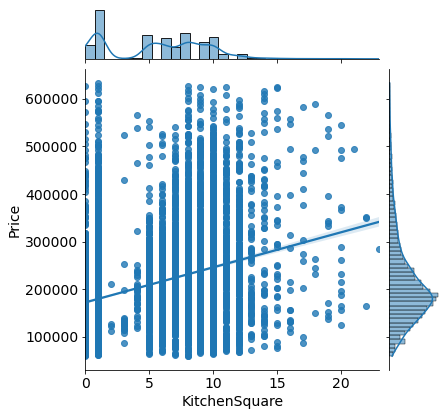

In [51]:
mask = train_df['KitchenSquare'] < 25
grid = sns.jointplot(train_df[mask]['KitchenSquare'], train_df[mask]['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)
plt.show()

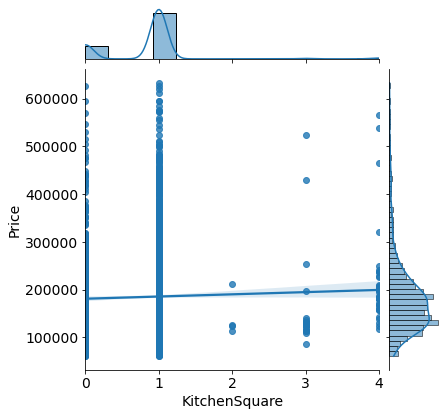

In [52]:
mask = train_df['KitchenSquare'] < 5
grid = sns.jointplot(train_df[mask]['KitchenSquare'], train_df[mask]['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)
plt.show()

In [53]:
mask = (train_df['KitchenSquare'] < 25) & (train_df['KitchenSquare'] > 4)
train_df[mask].describe()['KitchenSquare']

count    6735.000000
mean        8.001336
std         2.389864
min         5.000000
25%         6.000000
50%         8.000000
75%        10.000000
max        23.000000
Name: KitchenSquare, dtype: float64

Пропусков нет, но есть нулевые значения, а также аномально большие - выбросы. 

<u>Обработка выбросов:</u> Выбросом считается площадь < 4 и > 25. Если площадь кухни выходит за рамки общей площади, тогда считаем новое значение как умножение доли от общей площади (отноешние средних или медиан KitchenSquare и Square) на общую площадь квартиры. Среднее и медиана KitchenSquare должны быть посчитаны 

<u>Обработка пропусков:</u> Пропусков нет.

**Floor**

In [54]:
train_df['Floor'].value_counts().sort_index()

1     235
2     588
3     872
4     949
5     876
6     802
7     759
8     643
9     604
10    553
11    457
12    438
13    398
14    362
15    287
16    290
17    256
18    185
19    121
20     68
21     59
22     54
23     25
24     53
25     34
26     18
27      5
28      3
31      1
32      2
33      1
37      1
42      1
Name: Floor, dtype: int64

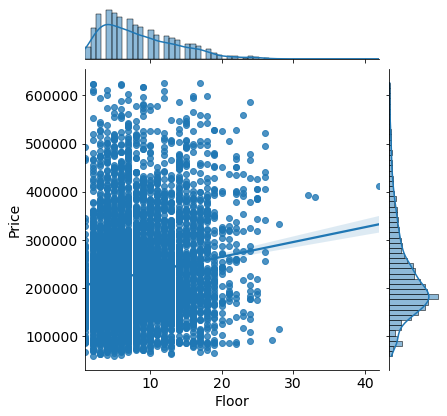

In [55]:
grid = sns.jointplot(train_df['Floor'], train_df[mask]['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)
plt.show()

Пропусков нет, аномалий не наблюдается.

In [56]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839512,21.058716,86.241219,28.560839,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


**HouseFloor**

In [57]:
train_df['HouseFloor'].value_counts().sort_index()

0       269
1       497
2        48
3       127
4       134
5      1031
6        58
7        59
8       141
9      1389
10      135
11       28
12     1074
13       27
14      625
15      123
16      576
17     2331
18       89
19      108
20      105
21       33
22      343
23       40
24      176
25      374
26        1
27        6
28        3
29        1
30       21
31        1
32        4
36        1
37        4
38        1
39        2
40        7
44        1
45        1
47        1
48        2
99        2
117       1
Name: HouseFloor, dtype: int64

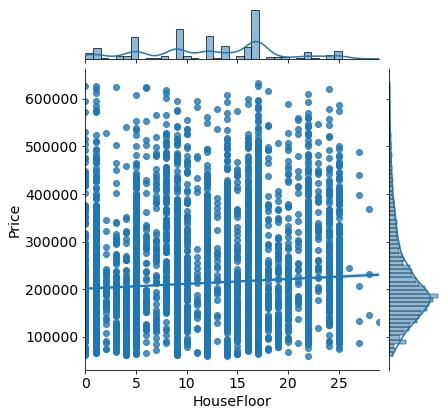

In [58]:
mask = train_df['HouseFloor'] < 30
grid = sns.jointplot(train_df[mask]['HouseFloor'], train_df[mask]['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)
plt.show()

In [59]:
train_df[train_df['HouseFloor'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
24,4717,27,1,44.203945,NaN,0.0,2,0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.562500
152,12947,53,2,56.023342,NaN,0.0,14,0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,247074.562500
159,13146,74,1,46.449711,NaN,0.0,6,0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,168705.453125
186,12174,62,1,44.954880,NaN,0.0,8,0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,133773.296875
229,15661,45,3,81.094925,NaN,0.0,15,0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,442472.468750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9889,629,27,1,42.936726,NaN,0.0,2,0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,129674.843750
9931,15686,1,1,47.402412,NaN,0.0,14,0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,174740.296875
9940,4711,6,1,41.224117,NaN,0.0,8,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,125612.640625
9950,5383,48,3,98.994911,NaN,0.0,3,0,1977,0.041125,B,B,46,9515,5,NaN,1,10,B,418817.000000


In [60]:
train_df[(train_df['HouseFloor'] == 0) & (train_df['Floor'] == 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [61]:
train_df[train_df['HouseFloor'] > 50]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
746,9300,74,2,71.747871,74.579811,9.0,5,99,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,243329.90625
1678,78,30,2,65.773750,66.811790,1.0,8,117,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,207248.37500
4657,10806,5,1,51.944588,48.709602,1.0,6,99,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,296127.12500


Пропусков нет, но есть нулевые значения, а также 3 больших значения, как будто квартира находится в небоскребе. 

<u>Обработка выбросов:</u> Попробуем присвоить максимальный этаж дома к этажу квартиры для домов чей максимальный этаж ниже этажа квартиры

<u>Обработка пропусков:</u> Пропусков нет.

**HouseYear**

In [62]:
train_df['HouseYear'].value_counts().sort_index()

1910          1
1912          2
1914          1
1916          1
1917          3
           ... 
2018        175
2019         79
2020         19
4968          1
20052011      1
Name: HouseYear, Length: 97, dtype: int64

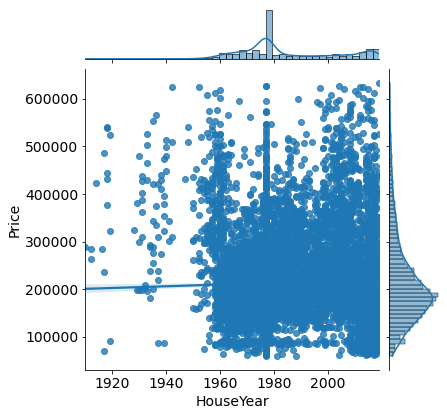

In [63]:
mask = train_df['HouseYear'] < 2020
grid = sns.jointplot(train_df[mask]['HouseYear'], train_df[mask]['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)
plt.show()

Пропусков нет, есть 2 аномальных значения.

<u>Обработка выбросов:</u> Если обратиться к матрице корреляций, то данный признак не оказывает почти никакого влияния. Удалим весь столбец признаков.

<u>Обработка пропусков:</u> Пропусков нет.

**Ecology_1**

In [64]:
train_df['Ecology_1'].value_counts().sort_index()

0.000000e+00    537
1.800000e-09     10
6.998930e-05     83
7.815280e-05    245
1.696760e-04     70
               ... 
4.378853e-01    137
4.581745e-01     67
4.605564e-01     31
4.862456e-01     22
5.218670e-01     39
Name: Ecology_1, Length: 129, dtype: int64

Про признак ничего неизвестно, оставим без изменений. Пропусков нет.

**Social_1, Social_2, Social_3**

In [65]:
train_df['Social_1'].value_counts().sort_index().head()

0    201
1    654
2    688
3      9
4    141
Name: Social_1, dtype: int64

In [66]:
train_df['Social_1'].value_counts().sort_index().tail()

50     79
52    201
53    355
66     99
74    176
Name: Social_1, dtype: int64

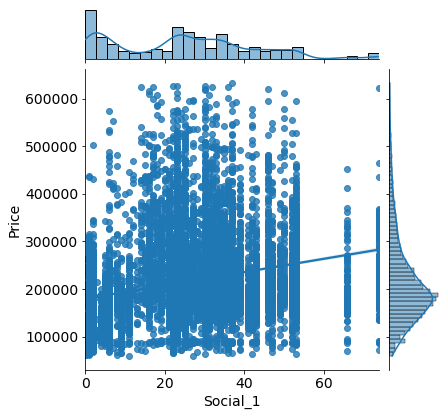

In [67]:
grid = sns.jointplot(train_df['Social_1'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)
plt.show()

In [68]:
train_df['Social_2'].value_counts().sort_index()

168      190
186       11
264      587
290       11
388       56
        ... 
11395     95
12238     79
13670    204
14892    151
19083    176
Name: Social_2, Length: 142, dtype: int64

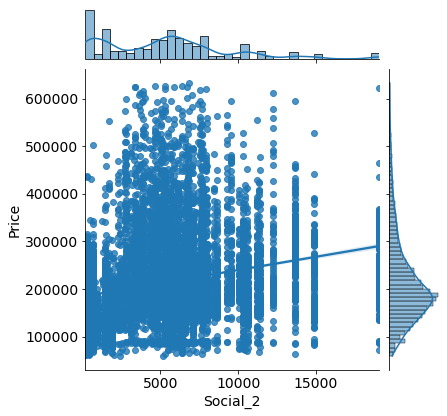

In [69]:
grid = sns.jointplot(train_df['Social_2'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)
plt.show()

In [70]:
train_df['Social_3'].value_counts().head()

0    2997
1    1861
3    1136
4     835
2     635
Name: Social_3, dtype: int64

In [71]:
train_df['Social_3'].value_counts().tail()

23    18
39    15
73    10
45     9
37     3
Name: Social_3, dtype: int64

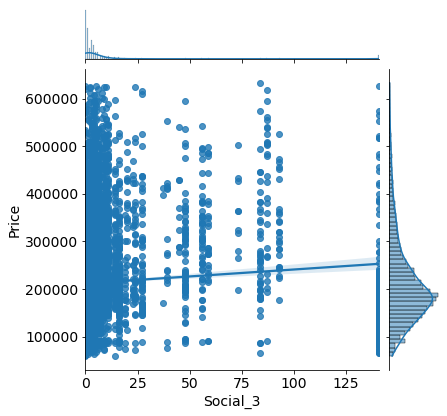

In [72]:
grid = sns.jointplot(train_df['Social_3'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)
plt.show()

Про признаки ничего неизвестно, оставим без изменений. Пропусков нет.

**Healthcare_1, Healthcare_2**

In [73]:
train_df['Healthcare_1'].value_counts().sort_values()

0.0         1
35.0        2
1815.0     10
32.0       12
370.0      14
         ... 
229.0     148
750.0     163
1046.0    245
30.0      348
540.0     511
Name: Healthcare_1, Length: 79, dtype: int64

In [74]:
train_df['Helthcare_2'].value_counts()

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

In [75]:
train_df[train_df['Healthcare_1'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3,115.027313,NaN,10.0,4,10,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
3,2352,1,1,40.409908,NaN,1.0,10,22,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2,64.285065,38.562515,9.0,16,16,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750
8,9951,1,1,46.887894,44.628132,1.0,12,20,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.406250
11,16755,88,2,53.975143,34.153584,8.0,2,12,1978,0.127376,B,B,43,8429,3,NaN,3,9,B,253124.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,9289,1,3,84.486076,88.931511,0.0,4,22,2016,0.007122,B,B,1,264,0,NaN,0,1,B,264213.562500
9995,1260,61,2,49.090729,33.272625,6.0,3,12,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
9996,16265,27,2,64.307686,37.038422,9.0,13,0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250
9997,2795,178,1,29.648056,16.555363,5.0,3,5,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250


У признака *Healthcare_1* 4798 пропусков. О признаках нам ничего неизвестно.

<u>Обработка выбросов:</u> Непонятно.

<u>Обработка пропусков:</u> Можно попробовать заменить пропуски на среднее/медиану, посчитанные по каждому значению признака *Healthcare_2*, поскольку эти два признака коррелируют. Ну или можно просто удалить признак *Healthcare_1*. 

**Shops_1**

In [76]:
train_df['Shops_1'].value_counts().sort_values()

19      49
16      83
15     176
10     215
23     245
8      253
7      294
9      316
11     401
6      487
3      711
4      841
2      964
5     1324
1     1325
0     2316
Name: Shops_1, dtype: int64

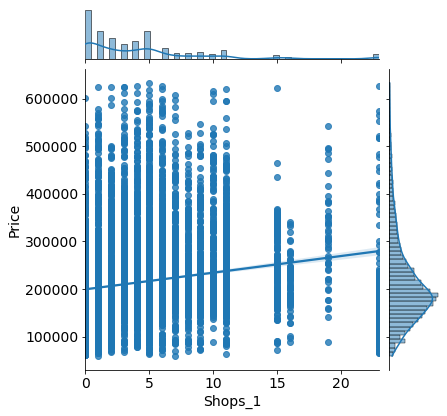

In [77]:
grid = sns.jointplot(train_df['Shops_1'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)
plt.show()

Про признак ничего неизвестно, оставим без изменений. Пропусков нет.

### Номативные признаки

In [78]:
train_df.select_dtypes(include='category').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [79]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [80]:
train_df.groupby(['Ecology_2'])['Price'].mean()

Ecology_2
A    193139.718750
B    214344.546875
Name: Price, dtype: float32

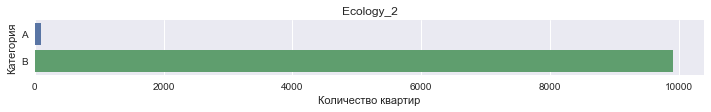

In [81]:
counts = train_df['Ecology_2'].value_counts()
plt.style.use('seaborn')
plt.figure(figsize=(12,1))    
plt.title('Ecology_2')
sns.barplot(counts.values,counts.index)
plt.xlabel('Количество квартир')
plt.ylabel('Категория')
plt.show()

In [82]:
train_df[train_df['Price'] > 400000]['Ecology_2'].value_counts()

B    541
A      1
Name: Ecology_2, dtype: int64

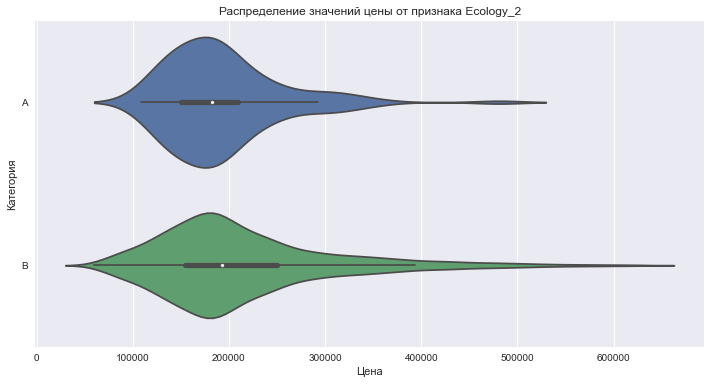

In [83]:
plt.figure(figsize=(12, 6))

sns.violinplot(train_df['Price'], train_df['Ecology_2'])
plt.xlabel('Цена')
plt.ylabel('Категория')
plt.title('Распределение значений цены от признака Ecology_2')
plt.show()

In [84]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [85]:
train_df.groupby(['Ecology_3'])['Price'].mean()

Ecology_3
A    243179.56250
B    213317.65625
Name: Price, dtype: float32

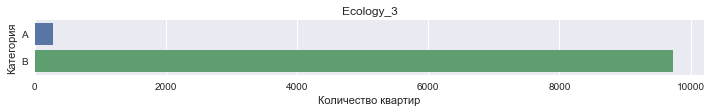

In [86]:
counts = train_df['Ecology_3'].value_counts()
    
plt.figure(figsize=(12,1))    
plt.title('Ecology_3')
sns.barplot(counts.values,counts.index)
plt.xlabel('Количество квартир')
plt.ylabel('Категория')
plt.show()

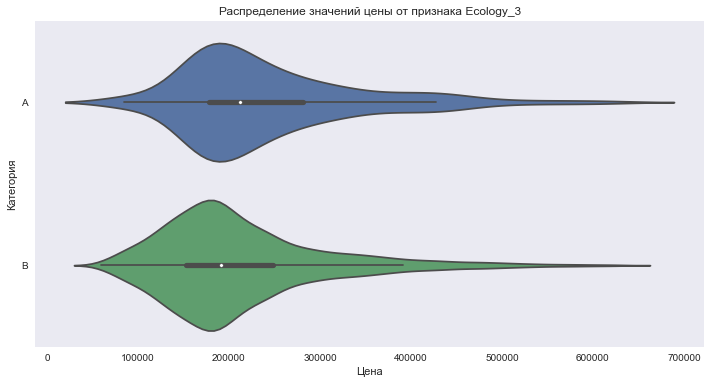

In [87]:
plt.figure(figsize=(12, 6))

sns.violinplot(train_df['Price'], train_df['Ecology_3'])

plt.xlabel('Цена')
plt.ylabel('Категория')
plt.grid(axis='x')
plt.title('Распределение значений цены от признака Ecology_3')
plt.show()

In [88]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [89]:
train_df.groupby(['Shops_2'])['Price'].mean()

Shops_2
A    192339.703125
B    216099.000000
Name: Price, dtype: float32

In [90]:
train_df.groupby(['Shops_2'])['Price'].median()

Shops_2
A    181620.000
B    193446.125
Name: Price, dtype: float32

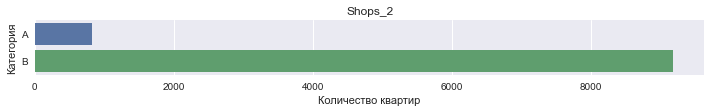

In [91]:
counts = train_df['Shops_2'].value_counts()
    
plt.figure(figsize=(12,1))    
plt.title('Shops_2')
sns.barplot(counts.values,counts.index)
plt.xlabel('Количество квартир')
plt.ylabel('Категория')
plt.show()

In [92]:
train_df[train_df['Price'] > 400000]['Shops_2'].value_counts()

B    529
A     13
Name: Shops_2, dtype: int64

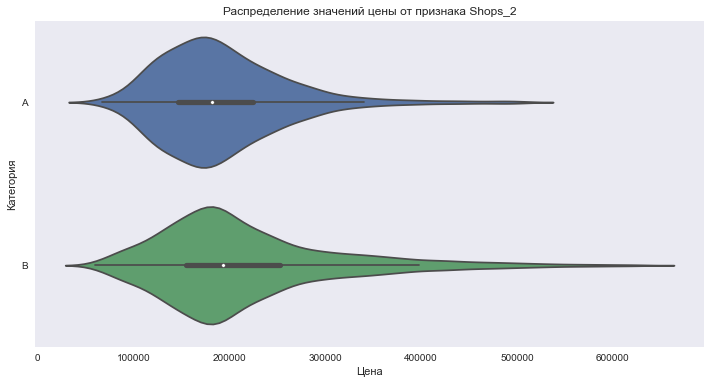

In [93]:
plt.figure(figsize=(12, 6))

sns.violinplot(train_df['Price'], train_df['Shops_2'])

plt.xlabel('Цена')
plt.ylabel('Категория')
plt.grid(axis='x')
plt.title('Распределение значений цены от признака Shops_2')
plt.show()

В номативных признаках несмотря на перевес одной категории над другой распределение цен примерно одинаковое. 

**Ecology_2, Shops_2:** Для очень дорогих квартир (от 400к) соответсвует только значение 'B'

### Матрица корреляций

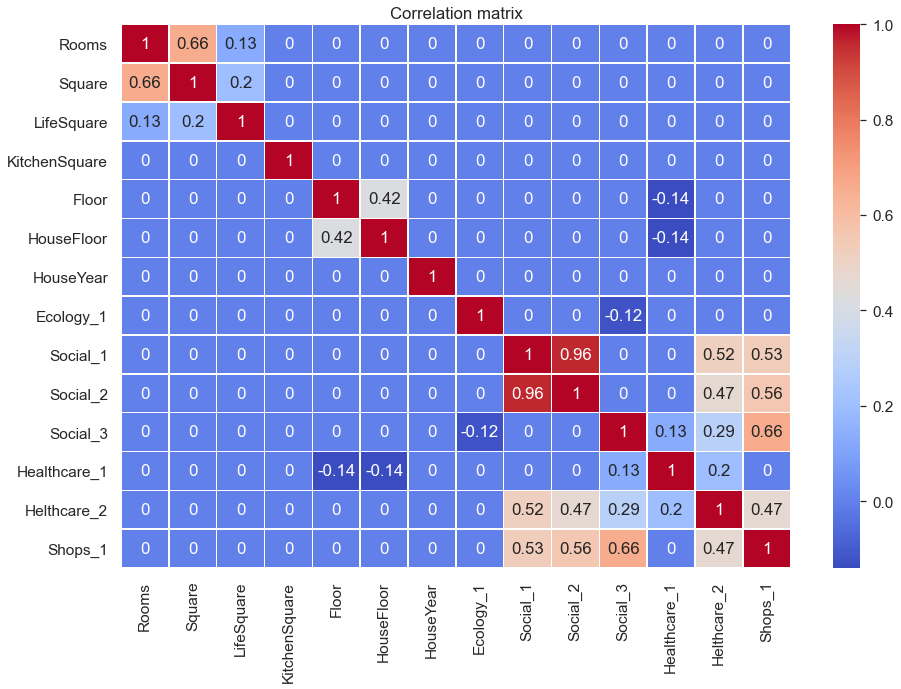

In [94]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.drop(columns='Price').corr()
corr_matrix = train_df.drop(columns='Price').corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.12] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

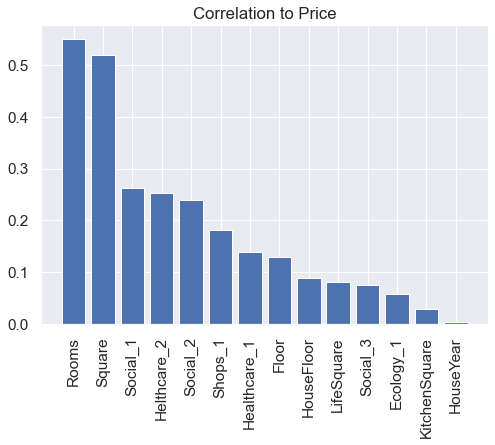

In [95]:
corr_matrix = train_df.loc[:, train_df.columns != 'Id'].corrwith(
    train_df['Price']).abs().sort_values(ascending=False)[1:]
plt.bar(corr_matrix.index, corr_matrix.values)
plt.title('Correlation to Price')
plt.xticks(rotation='vertical')
plt.show()

Видно что есть корреляция между *Rooms, Square, LifeSqaure*, значит в теории можно использовать эти данные для устранения выбросов и пропусков. Аналогично и для *Floor* и *HouseFloor*.

---
## 2. Обработка выбросов и пропусков <a class='anchor' id='nan'>

### Функции

In [96]:
def rooms_preprocessing(df):
    # замена выбросов на медианное значение
    rooms_median = df['Rooms'].median()
    df.loc[(df.Rooms < 1) | (df.Rooms > 6), 'Rooms']  = rooms_median
    return df

In [97]:
def square_preprocessing(df):
    # удаляем выбросы > 250
    df.drop(df[df['Square'] > 250].index, inplace=True)
    
    # замена низких выбросов
    mask = (df['Square'] < 150) & (df['Square'] > 8)
    stats_square_per_rooms = df[mask].groupby(['Rooms'])['Square'].describe()
    mean_and_std = stats_square_per_rooms[['mean', 'std']]
    mean_and_std.loc[mean_and_std['std'].isnull(), 'std'] = 0
    mean_and_std.reset_index(inplace=True)
    # создали фрейм со статистикой   
    incorrect_squares = df.loc[(df['Square'] < 8), ['Rooms', 'Square']]
    incorrect_squares.reset_index(inplace=True)
    correct_squares = pd.merge(incorrect_squares, mean_and_std)
    correct_squares['Square'] = np.random.uniform(correct_squares['mean'] - correct_squares['std'],
                                                  correct_squares['mean'] - correct_squares['std'])
    correct_squares.set_index('index', inplace=True)
    df.loc[correct_squares.index, 'Square'] = correct_squares['Square']
    return df

In [98]:
def life_and_kitchen_square_preprocessing(df):
    # расчет медиан для LifeSquare
    lsq = df.groupby(['Rooms'])['LifeSquare'].mean()
    # расчет медиан для Square
    sq = df.groupby(['Rooms'])['Square'].mean()
    # расчет доли медиан для LifeSquare
    lsq_sq_ratio = lsq/sq
    # расчет медиан для KitchenSquare
    ksq = df.groupby(['Rooms'])['KitchenSquare'].mean()
    sq = df.groupby(['Rooms'])['Square'].mean()
    # расчет доли медиан для KitchenSquare
    ksq_sq_ratio = ksq/sq
    
    # заполняем пропуски в LifeSquare
    mask = df['LifeSquare'].isna()
    df.loc[mask, 'LifeSquare'] = df.loc[mask, 'Square'] * df.loc[mask,'Rooms'].apply(lambda x: lsq_sq_ratio[x])
    
    # подрезать хвосты
    mask = df["LifeSquare"] < 6
    df.loc[mask, 'LifeSquare'] = df.loc[mask, 'Square'] * df.loc[mask,'Rooms'].apply(lambda x: lsq_sq_ratio[x])
    mask = df["KitchenSquare"] < 6
    df.loc[mask, 'KitchenSquare'] = df.loc[mask, 'Square'] * df.loc[mask,'Rooms'].apply(lambda x: ksq_sq_ratio[x])
    
    # обработка аномалий
    mask = df["Square"] <= df["LifeSquare"]
    df.loc[mask, 'LifeSquare'] = df.loc[mask, 'Square'] * df.loc[mask,'Rooms'].apply(lambda x: lsq_sq_ratio[x])
   
    mask = df["Square"] <= df["KitchenSquare"]
    df.loc[mask, 'KitchenSquare'] = df.loc[mask, 'Square'] * df.loc[mask,'Rooms'].apply(lambda x: ksq_sq_ratio[x])    
    
    mask = df["Square"] <= df["LifeSquare"] + df['KitchenSquare']
    df.loc[mask, 'KitchenSquare'] = df.loc[mask, 'Square'] * df.loc[mask,'Rooms'].apply(lambda x: ksq_sq_ratio[x])

    mask = df["Square"] <= df["LifeSquare"] + df['KitchenSquare']
    df.loc[mask, 'LifeSquare'] = df.loc[mask, 'Square'] * df.loc[mask,'Rooms'].apply(lambda x: lsq_sq_ratio[x])
    
    return df

In [99]:
# готово
def house_floor_preprocessing(df):
    mask = df['Floor'] > df['HouseFloor']
    df.loc[mask, 'HouseFloor'] = df.loc[mask, 'Floor']
    return df

In [100]:
def healthcare_1_preprocessing(df):
    if 'Healthcare_1' in df.columns:
        df.drop('Healthcare_1', axis=1, inplace=True)

    return df

In [101]:
def house_year_preprocessing(df):
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = 2011
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
    
    return df

In [102]:
def data_preprocessing(df):
    """ 
    Преобразование данных датасета:
        1. Обработка 'Rooms'
        2. Обработка 'Square'
        3. Обработка 'HouseYear'
        4. Обработка 'LifeSquare' & 'KitchenSquare'
        5. Обработка 'HouseFloor'
        6. Обработка 'Healthcare_1'
    """
    df = house_year_preprocessing(df)
    df = rooms_preprocessing(df)
    df = square_preprocessing(df)
    df = life_and_kitchen_square_preprocessing(df)
    df = house_floor_preprocessing(df)
    df = healthcare_1_preprocessing(df)

    return df 

In [103]:
def data_dummies(df):
    key_map = {'A': 0, 'B': 1}
    df['Ecology_2'] = df['Ecology_2'].replace(key_map)
    df['Ecology_3'] = df['Ecology_3'].replace(key_map)
    df['Shops_2'] = df['Shops_2'].replace(key_map)
    
    return df

### Обработка тренировочной выборки

In [104]:
train_df = data_preprocessing(train_df)
train_df = data_dummies(train_df)

In [105]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9996 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             9996 non-null   category
 1   DistrictId     9996 non-null   category
 2   Rooms          9996 non-null   float64 
 3   Square         9996 non-null   float32 
 4   LifeSquare     9996 non-null   float32 
 5   KitchenSquare  9996 non-null   float32 
 6   Floor          9996 non-null   int8    
 7   HouseFloor     9996 non-null   int8    
 8   HouseYear      9996 non-null   int32   
 9   Ecology_1      9996 non-null   float32 
 10  Ecology_2      9996 non-null   int64   
 11  Ecology_3      9996 non-null   int64   
 12  Social_1       9996 non-null   int8    
 13  Social_2       9996 non-null   int16   
 14  Social_3       9996 non-null   int16   
 15  Helthcare_2    9996 non-null   int8    
 16  Shops_1        9996 non-null   int8    
 17  Shops_2        9996 non-null   in

In [106]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
count,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000
mean,1.888555,56.188274,34.874332,7.570626,8.524810,13.433173,1984.857943,0.118850,0.990296,0.972589,24.686475,5352.003701,8.027111,1.318928,4.228992,0.917467,214137.906250
std,0.811612,18.952562,13.636665,2.322303,5.239944,6.089415,18.408130,0.119035,0.098034,0.163286,17.535983,4007.525703,23.799378,1.493600,4.803522,0.275189,92847.445312
min,1.000000,13.784864,8.822989,1.218403,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.782323,24.118776,6.000000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,0.000000,1.000000,1.000000,153891.656250
50%,2.000000,52.513309,32.292002,7.000000,7.000000,14.000000,1977.000000,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,1.000000,3.000000,1.000000,192290.039062
75%,2.000000,65.889736,42.325816,9.000000,12.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,2.000000,6.000000,1.000000,249135.460938
max,6.000000,212.932358,134.986755,42.000000,42.000000,117.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,6.000000,23.000000,1.000000,633233.437500


---
## 3. Построение новых признаков <a class='anchor' id='features'>

### Функции

In [107]:
def add_feature_district_size(df):
    district_size = train_df['DistrictId'].value_counts().reset_index().rename(columns={'index': 'DistrictId', 'DistrictId': 'DistrictSize'})
    df = pd.merge(df, district_size, on = 'DistrictId', how='left')
    df['DistrictSize'] = df['DistrictSize'].fillna(1)
    return df

In [108]:
def generate_mean_price_by_rooms(df):
    mean_by_rooms = df.groupby(['Rooms'], as_index=False)['Price'].mean()
    mean_by_rooms.rename(columns={'Price': 'MeanPriceByRooms'}, inplace=True)
    return mean_by_rooms

In [109]:
def add_feature_mean_price_by_rooms(df, mean_by_rooms):
    df = pd.merge(df, mean_by_rooms, on=['Rooms'], how='left')
    return df

In [110]:
def generate_mean_price_by_rooms_and_district(df):
    mean_per_rooms = df.groupby(['Rooms'])['Price'].mean()
    mean_by_rooms_and_district = df.groupby(['DistrictId', 'Rooms'], as_index=False)['Price'].mean()
    mean_by_rooms_and_district.rename(columns={'Price': 'MeanPriceByDistrictAndRooms'}, inplace=True)
    mask = mean_by_rooms_and_district['MeanPriceByDistrictAndRooms'].isna()
    mean_by_rooms_and_district.loc[mask, 'MeanPriceByDistrictAndRooms'] = mean_by_rooms_and_district.loc[mask, 'Rooms'].apply(lambda x: mean_per_rooms[x])
    
    return mean_by_rooms_and_district

In [111]:
def add_feature_mean_price_by_rooms_and_district(df, mean_by_rooms_and_district):
    df = pd.merge(df, mean_by_rooms_and_district, on=['DistrictId', 'Rooms'], how='left')
    return df

In [112]:
def add_features(df, mean_by_rooms, mean_by_rooms_and_district):
    """ 
    Добавление новых признаков:
        1. Средняя цена квартиры в зависимости от района и количества комнат.
        2. Средняя цена квартиры в зависимости от количества комнат.
        3. Размер района.
    """
    df = add_feature_district_size(df)
    df = add_feature_mean_price_by_rooms(df, mean_by_rooms)
    df = add_feature_mean_price_by_rooms_and_district(df, mean_by_rooms_and_district)
    
    return df

In [113]:
def add_feature_mean_price_by_rooms_for_test(df, mean_by_rooms, price_mean):
    df = pd.merge(df, mean_by_rooms, on=['Rooms'], how='left')
    df['MeanPriceByRooms']= df['MeanPriceByRooms'].fillna(price_mean)
    return df

In [114]:
def add_feature_mean_price_by_rooms_and_district_for_test(df, mean_by_rooms_and_district, price_mean):
    df = pd.merge(df, mean_by_rooms_and_district, on=['DistrictId', 'Rooms'], how='left')
    df['MeanPriceByDistrictAndRooms'] = df['MeanPriceByDistrictAndRooms'].fillna(price_mean)
    return df

In [115]:
def add_features_for_test(df, mean_by_rooms, mean_by_rooms_and_district, price_mean):
    """ 
    Добавление новых признаков:
        1. Средняя цена квартиры в зависимости от района и количества комнат.
        2. Средняя цена квартиры в зависимости от количества комнат.
        3. Размер района.
    """
    df = add_feature_district_size(df)
    df = add_feature_mean_price_by_rooms_for_test(df, mean_by_rooms, price_mean)
    df = add_feature_mean_price_by_rooms_and_district_for_test(df, mean_by_rooms_and_district, price_mean)
    
    return df

### Обработка тренировочной выборки

In [116]:
mean_by_rooms = generate_mean_price_by_rooms(train_df)
mean_by_rooms_and_district = generate_mean_price_by_rooms_and_district(train_df)
train_df = add_features(train_df, mean_by_rooms, mean_by_rooms_and_district)

---
## 4. Отбор признаков <a class='anchor' id='features_selection'>

In [117]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictSize',
 'MeanPriceByRooms',
 'MeanPriceByDistrictAndRooms']

In [118]:
feature_names = ['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

new_feature_names = [ 'DistrictSize', 'MeanPriceByRooms', 'MeanPriceByDistrictAndRooms']

target_name = 'Price'

---
## 5. Разбиение тренировочной выборки на train и valid <a class='anchor' id='split'>

In [119]:
# Посмотрим на размерности и пропуски в данных. После обработки их не должно быть.
print(train_df.shape)
print(train_df.isna().sum().sum())

(9996, 22)
0


In [120]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [121]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=21)

In [122]:
X_train.shape, X_valid.shape

((7996, 19), (2000, 19))

---
## 6. Построение модели <a class='anchor' id='modeling'>

### Обучение

In [123]:
gb_model = GradientBoostingRegressor(criterion='mse', max_features=7, max_depth=7, min_samples_leaf=9, n_estimators=175, random_state=21)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=7, max_features=7,
                          min_samples_leaf=9, n_estimators=175,
                          random_state=21)

In [124]:
# parameters = {
#     'n_estimators': [100,125,150,175,200],
#     'max_features': [5,7,9,11,13,15],
#     'max_depth': [5,7,9,11],
#     'min_samples_leaf': [8,9,10]
# #     'learning_rate': [0.06, 0.065, 0.07, 0.075, 0.08]
# }

# gb_model = GridSearchCV(
#     estimator=GradientBoostingRegressor(),
#     param_grid=parameters,
#     scoring='r2',
#     cv=5,
# )

# gb_model.fit(X, y)

# gb_model.best_params_

### Оценка модели

Train R2:	0.934
Test R2:	0.772


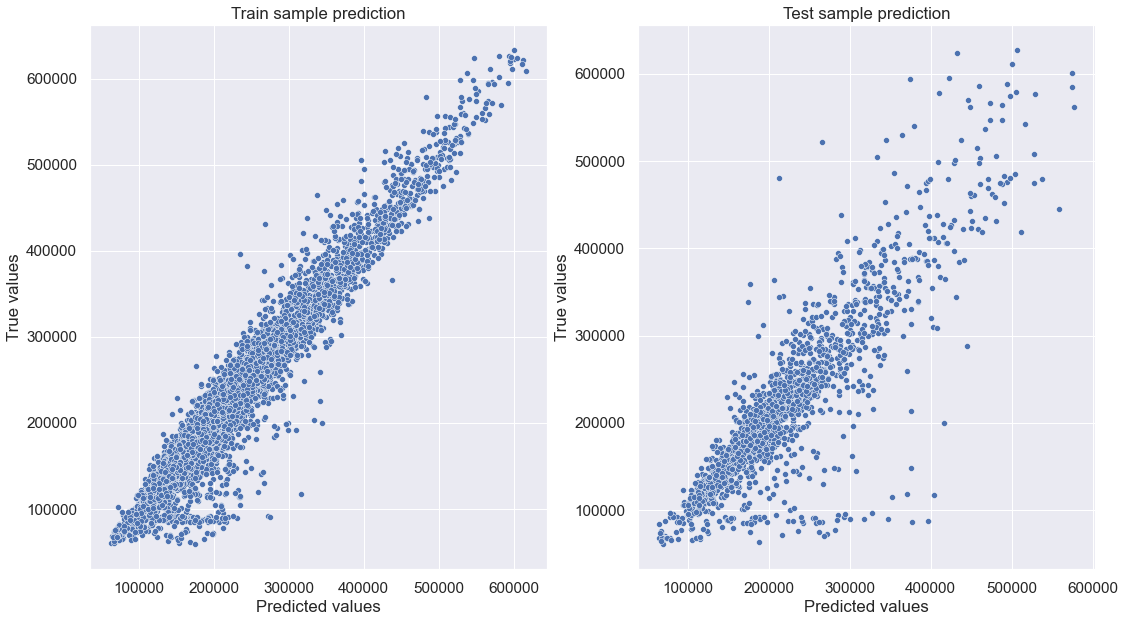

In [125]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### Кросс-валидация

In [126]:
cv_score = cross_val_score(gb_model, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

array([0.77963658, 0.7579726 , 0.76826916, 0.80188657, 0.77878527])

In [127]:
cv_score.mean()

0.7773100375452741

### Важность признаков

In [128]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
18,MeanPriceByDistrictAndRooms,0.489795
1,Square,0.123392
2,LifeSquare,0.067630
3,KitchenSquare,0.065255
16,DistrictSize,0.043505
10,Social_1,0.033946
6,HouseYear,0.029227
0,Rooms,0.027172
12,Social_3,0.021094
11,Social_2,0.018072


---
## 7. Прогнозирование на тестовом датасете <a class='anchor' id='prediction'>

In [129]:
gb_model = GradientBoostingRegressor(criterion='mse', max_features=7, max_depth=7, min_samples_leaf=9, n_estimators=175, random_state=21)
gb_model.fit(X, y)

GradientBoostingRegressor(criterion='mse', max_depth=7, max_features=7,
                          min_samples_leaf=9, n_estimators=175,
                          random_state=21)

In [130]:
cv_score = cross_val_score(gb_model, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score.mean()

0.7773100375452741

In [131]:
X.shape, y.shape

((9996, 19), (9996,))

In [132]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df = type_conversion(test_df)

'Id' type: <class 'str'> -> str
'DistrictId' type: <class 'str'> -> str
'Rooms' type: <class 'numpy.float64'> -> str
'HouseFloor' type: <class 'numpy.int8'> -> str
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.36 MB
Decreased by 50.3%


In [133]:
test_df = data_preprocessing(test_df)
test_df = data_dummies(test_df)

test_df = add_features_for_test(test_df, mean_by_rooms, mean_by_rooms_and_district, price_mean)

test_df = test_df[feature_names + new_feature_names]

In [134]:
test_df.shape, X.shape, y.shape

((5000, 19), (9996, 19), (9996,))

In [135]:
test_df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,DistrictSize,MeanPriceByRooms,MeanPriceByDistrictAndRooms
0,1.0,36.847630,19.094183,4.763471,5,9,1970,0.036122,1,1,24,4378,0,1,1,1,104.0,159869.53125,181458.578125
1,1.0,42.493908,25.522322,10.000000,7,17,2017,0.072158,1,1,2,629,1,0,0,0,247.0,159869.53125,132420.906250
2,2.0,59.463676,38.008781,9.000000,19,19,1977,0.211401,1,1,9,1892,0,0,1,1,851.0,215233.90625,166594.390625
3,3.0,49.646030,33.893826,6.000000,2,2,1965,0.014073,1,1,2,475,0,0,0,1,565.0,289337.96875,170912.203125
4,1.0,53.837055,32.335144,6.959776,8,17,1977,0.309479,1,1,35,7715,4,0,6,1,114.0,159869.53125,162101.000000


In [136]:
print(test_df.shape)
print(test_df.isna().sum().sum())

(5000, 19)
0


In [137]:
submit = pd.read_csv(SUBMIT_DATASET_PATH)
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [138]:
predictions = gb_model.predict(test_df)
predictions

array([168250.67762507, 120538.59231665, 144294.25688046, ...,
       149361.00870578, 178502.81838476, 251205.84082541])

In [139]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,168250.677625
1,5925,120538.592317
2,960,144294.256880
3,3848,124332.392163
4,746,176861.394708


In [140]:
submit.to_csv(SUBMIT_FILE_NAME, index=False)